## Vertical distribution of emissions

### Reading the vertical layering of the model

For the vertical distribution of emissions into the model layers, we read the model layer heights from `wrfinput`.

First, we need some imports:

In [1]:
from io import BytesIO

import numpy as np
import pandas as pd
import xarray as xr
import wrf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH = '/mnt/misc/aether/user/hilboll/prj/2017_cindi-2_wrfchem/wrf/erai-modis/test0007_20170502/WRFV3/run/wrfinput_d01'

The `wrfinput_d0X` file can be opened with xarray:

In [3]:
ds = xr.open_dataset(PATH)

The model layer altitude can be calculated from the *base state geopotential* `PH` and *perturbation geopotential* `PHB`.

In [4]:
var_ph = wrf.getvar(ds._file_obj.ds, 'PH')
var_phb = wrf.getvar(ds._file_obj.ds, 'PHB')

According to the [wrf-python source code](https://github.com/NCAR/wrf-python/blob/develop/fortran/wrf_constants.f90#L23), the gravitational acceleration is *9.81*.

In [5]:
z = (var_ph + var_phb) / 9.81
z

<xarray.DataArray (bottom_top_stag: 44, south_north: 210, west_east: 210)>
array([[[  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   2.141231e-01],
        [  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        ..., 
        [  0.000000e+00,   0.000000e+00, ...,   1.430293e+02,   1.540049e+02],
        [  0.000000e+00,   0.000000e+00, ...,   1.410385e+02,   1.523297e+02]],

       [[  3.351233e+01,   3.350624e+01, ...,   3.359531e+01,   3.380410e+01],
        [  3.350893e+01,   3.350301e+01, ...,   3.357607e+01,   3.356497e+01],
        ..., 
        [  3.164389e+01,   3.165490e+01, ...,   1.744284e+02,   1.853996e+02],
        [  3.164697e+01,   3.165774e+01, ...,   1.724226e+02,   1.837137e+02]],

       ..., 
       [[  1.946329e+04,   1.946338e+04, ...,   1.948253e+04,   1.948265e+04],
        [  1.946344e+04,   1.946353e+04, ...,   1.948361e+04,   1.948385e+04],
        ..., 
        [  1.931028e+04,   1.931158e+04, ...,   1.938800e+04,   1.938841e+04

This yields altitudes on the *staggered grid*, i.e., at the layer interfaces.

In order to get altitude above ground, we need to subtract the topography height `HGT`:

In [6]:
h_surf = wrf.getvar(ds._file_obj.ds, 'HGT')
h_surf

<xarray.DataArray 'HGT' (south_north: 210, west_east: 210)>
array([[   0.      ,    0.      ,    0.      , ...,    0.      ,    0.      ,
           0.214123],
       [   0.      ,    0.      ,    0.      , ...,    0.      ,    0.      ,
           0.      ],
       [   0.      ,    0.      ,    0.      , ...,   15.347553,   10.880167,
           0.      ],
       ..., 
       [   0.      ,    0.      ,    0.      , ...,  111.483315,  117.51693 ,
         142.629883],
       [   0.      ,    0.      ,    0.      , ...,  143.721802,  143.029327,
         154.004944],
       [   0.      ,    0.      ,    0.      , ...,  137.794724,  141.038513,
         152.329697]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -12.1618 -12.0042 -11.8463 ...
    XLAT     (south_north, west_east) float32 36.3869 36.4172 36.4471 ...
    Time     datetime64[ns] 2016-09-10
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  X

In [7]:
h = z - h_surf
h

<xarray.DataArray (bottom_top_stag: 44, south_north: 210, west_east: 210)>
array([[[     0.      ,      0.      , ...,      0.      ,      0.      ],
        [     0.      ,      0.      , ...,      0.      ,      0.      ],
        ..., 
        [     0.      ,      0.      , ...,      0.      ,      0.      ],
        [     0.      ,      0.      , ...,      0.      ,      0.      ]],

       [[    33.512325,     33.506245, ...,     33.595314,     33.589973],
        [    33.508926,     33.503006, ...,     33.576065,     33.564968],
        ..., 
        [    31.64389 ,     31.654903, ...,     31.399033,     31.394699],
        [    31.646967,     31.657743, ...,     31.384064,     31.384033]],

       ..., 
       [[ 19463.285156,  19463.378906, ...,  19482.527344,  19482.4375  ],
        [ 19463.443359,  19463.529297, ...,  19483.611328,  19483.853516],
        ..., 
        [ 19310.28125 ,  19311.576172, ...,  19244.974609,  19234.408203],
        [ 19310.191406,  19311.523438, ..

And indeed, we can see that the lowest level of this new array is indeed `0.0` everywhere:

In [8]:
h[0].max().values

array(0.0001220703125)

### How variable is the layer thickness?

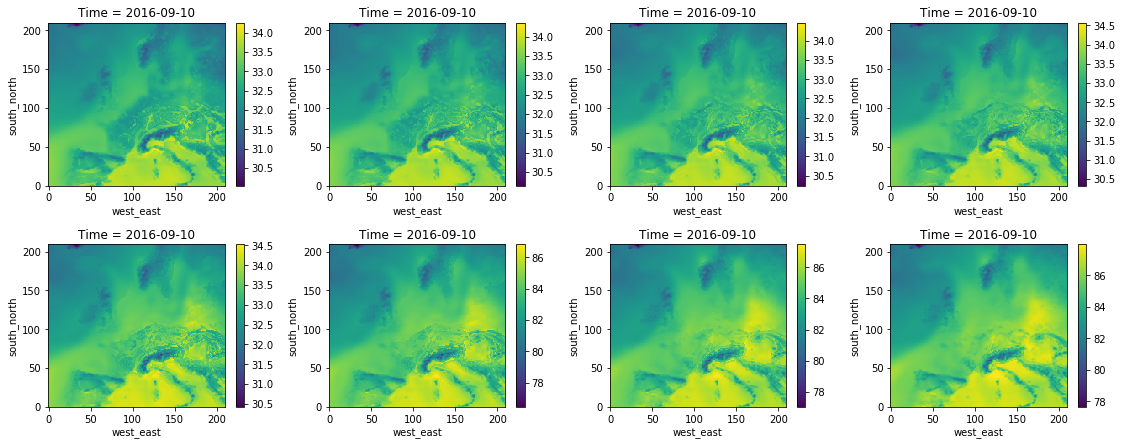

In [9]:
delta_h = h[1:] - h[:-1]
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(40/2.54, 16/2.54))

for i in range(8):
    _ = delta_h[i].plot(ax=axs.ravel()[i])
fig.tight_layout()

### Defining the vertical distribution of emission sources (here: from EMEP)

The definition of the vertical levels can be found in Table S3 in [Simpson et al. (2012)](https://doi.org/10.5194/acp-12-7825-2012):

In [10]:
z_emep = [0., 92., 184., 324., 522., 781., 1106]
zmin_emep, zmax_emep = z_emep[:-1], z_emep[1:]
df_emep = pd.DataFrame()
df_emep['z_min'] = zmin_emep
df_emep['z_max'] = zmax_emep
df_emep['SNAP1'] = [0., 0., .15, .4, .3, .15]
df_emep['SNAP2'] = [1., 0., 0., 0., 0., 0.]
df_emep['SNAP3'] = [.1, .1, .15, .3, .3, .05]
df_emep['SNAP4'] = [.9, .1, 0., 0., 0., 0.]
df_emep['SNAP5'] = [.9, .1, 0., 0., 0., 0.]
df_emep['SNAP6'] = [1., 0., 0., 0., 0., 0.]
df_emep['SNAP7'] = [1., 0., 0., 0., 0., 0.]
df_emep['SNAP8'] = [1., 0., 0., 0., 0., 0.]
df_emep['SNAP9'] = [.1, .15, .4, .35, .0, .0]
df_emep['SNAP10'] = [1., 0., 0., 0., 0., 0.]

assert (df_emep[[c for c in df_emep.columns if c.startswith('SNAP')]].sum() == 1.).all()

df_emep

z_min   z_max  SNAP1  SNAP2  SNAP3  SNAP4  SNAP5  SNAP6  SNAP7  SNAP8  \
0    0.0    92.0   0.00    1.0   0.10    0.9    0.9    1.0    1.0    1.0   
1   92.0   184.0   0.00    0.0   0.10    0.1    0.1    0.0    0.0    0.0   
2  184.0   324.0   0.15    0.0   0.15    0.0    0.0    0.0    0.0    0.0   
3  324.0   522.0   0.40    0.0   0.30    0.0    0.0    0.0    0.0    0.0   
4  522.0   781.0   0.30    0.0   0.30    0.0    0.0    0.0    0.0    0.0   
5  781.0  1106.0   0.15    0.0   0.05    0.0    0.0    0.0    0.0    0.0   

   SNAP9  SNAP10  
0   0.10     1.0  
1   0.15     0.0  
2   0.40     0.0  
3   0.35     0.0  
4   0.00     0.0  
5   0.00     0.0

### Calculating weighting factors per model level

We calculate a matrix of weighting factors to translate the vertical layering of the emission sources to the vertical model layers.  

In [11]:
model_layer = range(h.shape[0] - 1)
emis_layer = df_emep.index

factor = np.zeros((len(emis_layer), ) + (h.shape[0] - 1, ) + h.shape[1:])

for ml in model_layer:
    for el in emis_layer:
        if h[ml].values.min() > df_emep['z_max'].max():
            break
        upper = np.minimum(h[ml + 1].values, df_emep['z_max'].iloc[el])
        lower = np.maximum(h[ml].values, df_emep['z_min'].iloc[el])
        overlap = np.maximum(upper - lower, 0.)
        factor[el, ml] = overlap / (df_emep['z_max'].iloc[el] - df_emep['z_min'].iloc[el])
        
assert np.allclose(factor.sum(axis=0).sum(axis=0), emis_layer.max() + 1)

In [12]:
for ml in model_layer:
    print(factor[:, ml, 105, 105])

[ 0.35342324  0.          0.          0.          0.          0.        ]
[ 0.35641032  0.          0.          0.          0.          0.        ]
[ 0.29016644  0.06922523  0.          0.          0.          0.        ]
[ 0.          0.36234939  0.          0.          0.          0.        ]
[ 0.          0.36511281  0.          0.          0.          0.        ]
[ 0.          0.20331259  0.47045213  0.          0.          0.        ]
[ 0.          0.          0.52954787  0.05595537  0.          0.        ]
[ 0.          0.          0.          0.43271014  0.          0.        ]
[ 0.          0.          0.          0.43609294  0.          0.        ]
[ 0.          0.          0.          0.07524155  0.27847701  0.        ]
[ 0.          0.          0.          0.          0.33858463  0.        ]
[ 0.          0.          0.          0.          0.34118322  0.        ]
[ 0.          0.          0.          0.          0.04175512  0.24073844]
[ 0.          0.          0.          

### Applying weighting factors to individual emission sources

Before applying these weighting factors to the individual emission sources, we transpose the weights array in order to speed up lookups of the transformation matrix:

In [13]:
factor = factor.transpose(2, 3, 1, 0)

Now, calculating the array of weights per model-layer for a list of emission sources becomes simple:

In [14]:
weights_emis = df_emep['SNAP3'].values
ix_geoloc_x, ix_geoloc_y = [0, 1], [1, 2]
np.dot(factor[ix_geoloc_x, ix_geoloc_y], weights_emis)

array([[ 0.03641983,  0.03650749,  0.03659634,  0.03668413,  0.03676799,
         0.09126583,  0.09823736,  0.13056395,  0.1315696 ,  0.10501251,
         0.10224079,  0.10313171,  0.01815757,  0.01394153,  0.01406434,
         0.00883902,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.03640791,  0.03649765,  0.03658518,  0.03667282,  0.03675723,
         0.09124096,  0.09818155,  0.13055235,  0.13155804,  0.10504133,
         0.10223365,  0.10313412,  0.01827613,  0.01394473,  0.01406889,
         0.00884745,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
   